# K-means Model

- Author: [@vanstrouble](https://github.com/vanstrouble)

- You can have a look at the K-means algorithm code [here](src/kmeans.py).

K-means is a centroid-based iterative clustering algorithm that divides a dataset into similar groups based on the distance between their centroids. The centroid, or centre of the cluster, is the mean or median of all points within the cluster, depending on the characteristics of the data.

K-means++ is an enhancement of the K-means algorithm that optimizes the selection of initial centroids. Developed by Arthur and Vassilvitskii, K-means++ significantly improves the final clustering quality by reducing the likelihood of the algorithm getting stuck in local minima.

The initialization process in K-means++ begins by randomly selecting the first centroid from the dataset. For each subsequent centroid, the distance of each data point to its nearest already-selected centroid is calculated. The next centroid is then chosen based on a probability distribution that favors points further from their nearest centroid, meaning points that are farther away have a higher chance of being selected. This process continues until the desired number of centroids has been initialized.

|       Pros       |       Cons       |
| ---------------- | ------- |
| Easy to implement | Must manually chose K |
| Always converges to local minimum | Not guaranteed to find global minimum |
| Scales well to large datasets | May not perform well on data of varying density |
| Generalizes to clusters of different shapes and sizes | Clusters are biased by outliers |

In [1]:
import numpy as np
import cv2
import warnings
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, load_iris, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from src.kmeans import Kmeans

warnings.filterwarnings('ignore')

### Display Cluster Function

I have developed the ```display_cluster``` function to illustrate the functionality of the KMeans clustering model, tailored for use within Jupyter Notebook environments.

The ```display_cluster``` function visualizes data distribution through a scatter plot, showcasing clusters produced by a clustering algorithm (such as KMeans) along with their centroids.

This function creates a 2D scatter plot utilizing matplotlib and seaborn for enhanced styling. Data points are color-coded based on their assigned clusters, and cluster centroids are highlighted with a cross marker. The visualization allows for customizable axis labels and a descriptive title, ensuring clarity and flexibility in presenting clustering results.

In [2]:
def display_cluster(X, model=None, num_clusters=0, **kwargs):
    """Show clusters in 2D with Jupyter Notebooks format."""
    sns.set_theme(context="notebook", style="whitegrid")

    # Verify dataset shape
    if X.shape[1] < 2:
        raise ValueError(
            "Dataset X must have at least two features (columns) for 2D visualization"
        )

    # If num_clusters is not specified, use the number of clusters in km
    if model is not None and num_clusters == 0:
        num_clusters = len(model.k)

    # Verify if the number of clusters is valid
    if model is not None and num_clusters > len(model.centroids):
        raise ValueError(
            f"The specified number of clusters ({num_clusters}) is larger than the number of clusters in the model ({len(model.centroids)})"
        )

    # Create color palette based on number of clusters
    if num_clusters > 0:
        palette = sns.color_palette("husl", num_clusters)
    else:
        palette = sns.color_palette("husl", 1)  # Generate at least one color

    alpha = 0.5
    s = 20

    if num_clusters == 0 or model is None:
        plt.scatter(X[:, 0], X[:, 1], color=palette[0], alpha=alpha, s=s)
    else:
        for i, color in enumerate(palette):
            cluster_data = X[model.labels == i]
            plt.scatter(
                cluster_data[:, 0], cluster_data[:, 1], color=color, alpha=alpha, s=s
            )
            plt.scatter(
                model.centroids[i, 0],
                model.centroids[i, 1],
                color="red",
                marker="x",
                s=100,
                edgecolor="black",
            )

    plt.title(kwargs.get("title", f"Cluster Visualization with {num_clusters} cluster/s"))
    plt.xlabel(kwargs.get("feature_x", "Default Feature x"))
    plt.ylabel(kwargs.get("feature_y", "Default Feature y"))
    plt.show()

### Determining optimium number of clusters - Make Blobs Testing

Let's create a new dataset that visually consists on a few clusters and try to group them.

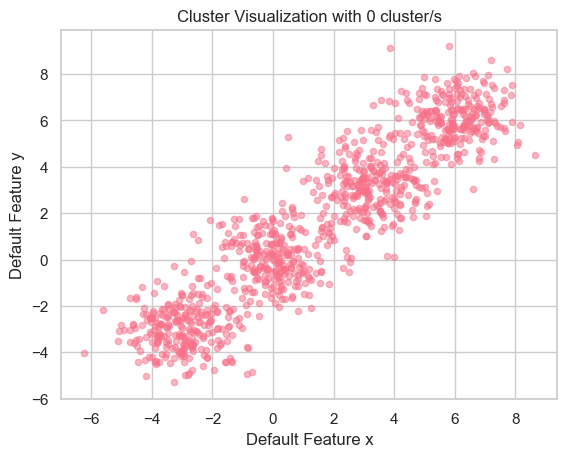

In [3]:
n_samples = 1000
n_bins = 4
centers = [(-3, -3), (0, 0), (3, 3), (6, 6)]
X_blobs, _ = make_blobs(
    n_samples=n_samples,
    n_features=2,
    cluster_std=1.0,
    centers=centers,
    shuffle=False,
    random_state=42,
)

display_cluster(X_blobs)

How many clusters do you observe?

Let's run K-means with seven clusters.

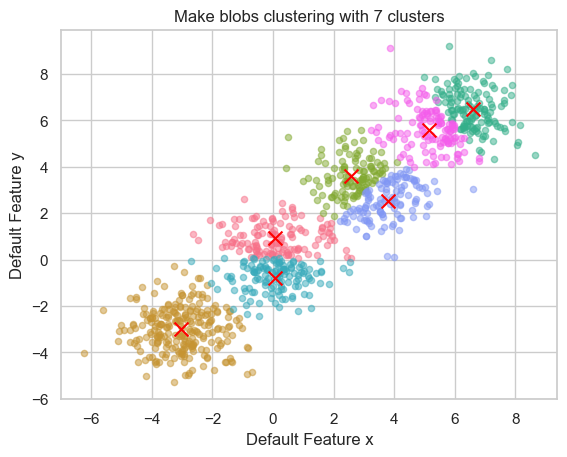

In [4]:
num_clusters = 7
km = Kmeans(k=num_clusters)
labels, centroids = km.predict(X_blobs)

display_cluster(X_blobs, km, num_clusters, title="Make blobs clustering with 7 clusters")

Now let's re-run the algorithm with four clusters.

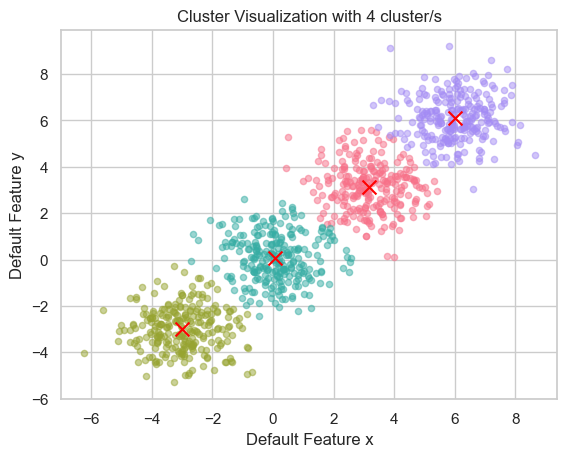

In [5]:
num_clusters = 4
km = Kmeans(k=num_clusters)
labels, centroids = km.predict(X_blobs)
display_cluster(X_blobs, km, num_clusters)

Should we use four or seven clusters?  

- In this case it may be visually obvious that four clusters is better than seven.  
- This is because we can easily view the data in two dimensional space.  
- However, real world data usually has more than two dimensions.  
- A dataset with a higher dimensional space is hard to visualize.  
- A way of solving this is to plot the **inertia** 

**inertia**: (sum of squared error between each point and its cluster center) as a function of the number of clusters. 

### Elbow Method

The elbow method is a popular technique for determining the optimal number of clusters in k-means clustering. It involves plotting the "within-cluster sum of squares" (WCSS) against the number of clusters, k. The WCSS measures the Euclidean distance between each data point and the centroid of its assigned cluster. As the number of clusters increases, the WCSS decreases. The point where the decrease in WCSS begins to level off—resembling an "elbow" in the plot—is often considered the optimal number of clusters. This point represents a balance between reducing variance within clusters and avoiding unnecessary complexity.

In [74]:
def elbow_method(
    X=None, max_clusters=10, step=1, title=None, k_vals=None, inertia=None
):
    if k_vals is not None and inertia is not None:
        list_num_clusters = k_vals
    else:
        assert X is not None, "X must be provided if k_vals and inertia are not"
        list_num_clusters = np.arange(2, max_clusters + 1, step)
        inertia = np.zeros(len(list_num_clusters))

        for i, num_clusters in enumerate(list_num_clusters):
            km = Kmeans(num_clusters)
            km.predict(X, inertia=True)
            inertia[i] = km.inertia

    sns.set_theme(context="notebook", style="whitegrid")
    plt.fill_between(list_num_clusters, inertia, color="royalblue", alpha=0.2)
    plt.scatter(list_num_clusters, inertia)
    plt.xticks(list_num_clusters)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.title(f"Elbow Method {title}")
    plt.tight_layout()
    plt.show()

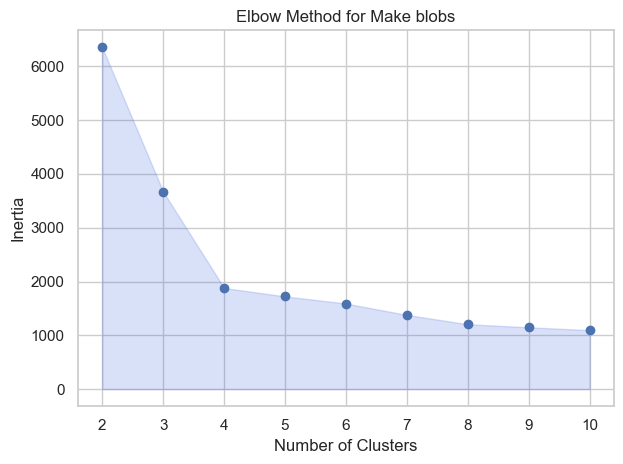

In [76]:
elbow_method(X_blobs, title="for Make blobs")

### Silhouette Score

While the elbow method is useful, it may not be the best choice for data sets with high dimensionality or irregular shapes. In such cases, silhouette analysis provides a more robust alternative for evaluating cluster quality. The silhouette score measures how similar each point is to its own cluster compared to other clusters, helping to identify the most appropriate number of clusters.

In [8]:
def silhouette_analysis(X, max_clusters=10, title=None):
    list_num_clusters = np.arange(2, max_clusters + 1)
    silhouette_scores = np.zeros(len(list_num_clusters))

    for i, num_clusters in enumerate(list_num_clusters):
        km = Kmeans(num_clusters)
        km.predict(X)
        silhouette_scores[i] = silhouette_score(X, km.labels)

    sns.set_theme(context="notebook", style="whitegrid")
    plt.fill_between(list_num_clusters, silhouette_scores, color='indianred', alpha=0.2)
    plt.scatter(list_num_clusters, silhouette_scores)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title(f"Silhouette Method {title}")
    plt.tight_layout()
    plt.show()

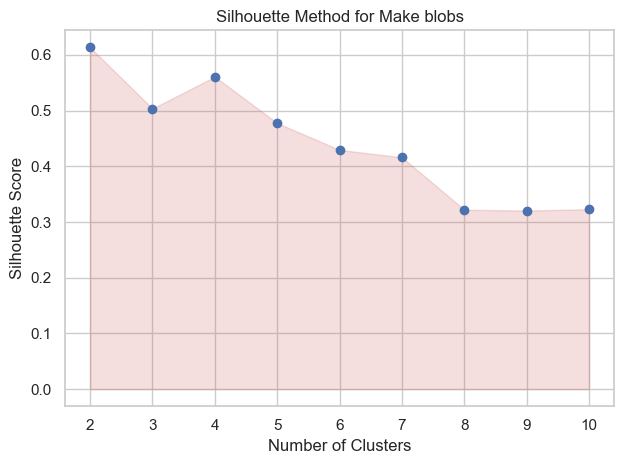

In [9]:
silhouette_analysis(X_blobs, title="for Make blobs")

It is normal that the silhouette plot does not always perfectly match the elbow method plot. Each metric captures different aspects of clustering quality:

1. **Elbow method**: measures how compact the clusters are. It seeks to minimize the sum of the squared distances from each point to its nearest centroid. An "elbow" in the plot indicates the point where adding more clusters no longer significantly reduces the inertia.

2. **Silhouette index**: Evaluates how well separated a cluster is from the others. A high silhouette value indicates that the clusters are well defined and separated. The silhouette score may not be high if the clusters are close together or if there is overlap between them.

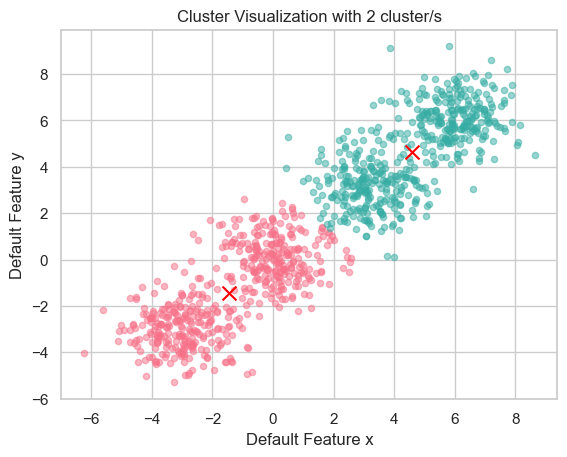

In [10]:
num_clusters = 2
km = Kmeans(k=num_clusters)
labels, centroids = km.predict(X_blobs)
display_cluster(X_blobs, km, num_clusters)

### Make Blobs Conclusion

In this case, the inertia metric and the silhouette score are giving different signals. We can choose the number of clusters based on the metric that best reflects the objective of the analysis:

- If we prefer well separated clusters, we can use the silhouette score and opt for 2 clusters.

- If we prefer more compact clusters, the elbow method and inertia suggest 4 clusters.

**In the end, the decision depends on the context of the analysis and the interpretation we want to make of the data.**

## Iris Plant Dataset Testing

- [Scikit-Learn The Iris Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html#sphx-glr-auto-examples-datasets-plot-iris-dataset-py)

This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray

The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.


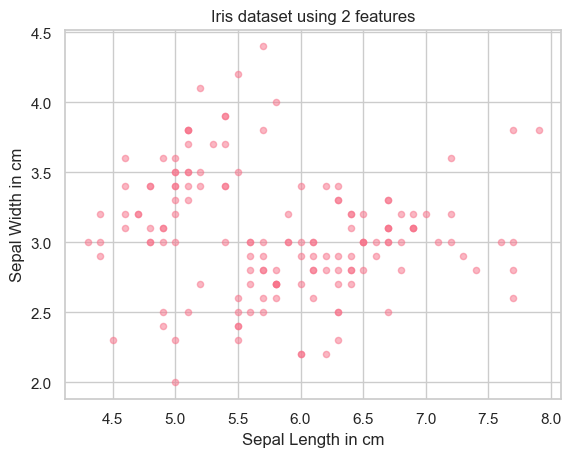

In [11]:
X_iris = load_iris().data

display_cluster(
    X_iris,
    title="Iris dataset using 2 features",
    feature_x="Sepal Length in cm",
    feature_y="Sepal Width in cm",
)

### Why is Standardizing Generally Better for K-means?

- **K-means is based on Euclidean distance**: In K-means, the algorithm minimizes the sum of the squared distances between the points and their respective centroids. If the features have very different scales, the distance will be dominated by the features with larger scale, which can lead to unrepresentative results. Standardizing helps to ensure that all features contribute equally to the calculated distances.

- **Similar dispersion between features**: Standardizing helps ensure that all features have similar dispersion, which ensures that one feature does not have excessive weight in the distance calculation.

In [12]:
X_iris_std = StandardScaler().fit_transform(X_iris)

### Pairplot

The pairplot is a crucial tool for unsupervised learning, particularly for K-means classification. By displaying all possible pairs of features in a single plot, the pairplot helps identify relevant patterns and relationships between variables. This visualization aids in detecting redundant or irrelevant features, enabling more precise selection of the variables that truly contribute to the data structure.

Effective feature selection using the pairplot can simplify the K-means algorithm by reducing the dataset's dimensionality. This not only lowers computational overhead but also enhances cluster detection accuracy, providing a clearer and more useful representation of the underlying data structure.

In [13]:
def pairplot(X, title="Pairplot of Features"):
    num_features = X.shape[1]

    _, axes = plt.subplots(num_features, num_features, figsize=(10, 10))

    num_plots = num_features * (num_features - 1) // 2
    palette = sns.color_palette("Dark2", num_plots**2)
    palette_hist = sns.color_palette("inferno", num_plots)

    color_idx = 0

    # Loop through feature pairs
    for i in range(num_features):
        for j in range(num_features):
            ax = axes[i, j]

            if i == j:
                # Histogram on the diagonal
                ax.hist(
                    X[:, i],
                    bins=20,
                    color=palette_hist[color_idx % num_plots],
                    alpha=0.7,
                )
            else:
                # Off-diagonal scatter plot
                ax.scatter(
                    X[:, j],
                    X[:, i],
                    alpha=0.5,
                    s=10,
                    color=palette[color_idx + 2 % num_plots],
                )
                color_idx += 1

            # Etiquetas de los ejes
            if i == num_features - 1:
                ax.set_xlabel(f"Feature {j}")
            if j == 0:
                ax.set_ylabel(f"Feature {i}")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

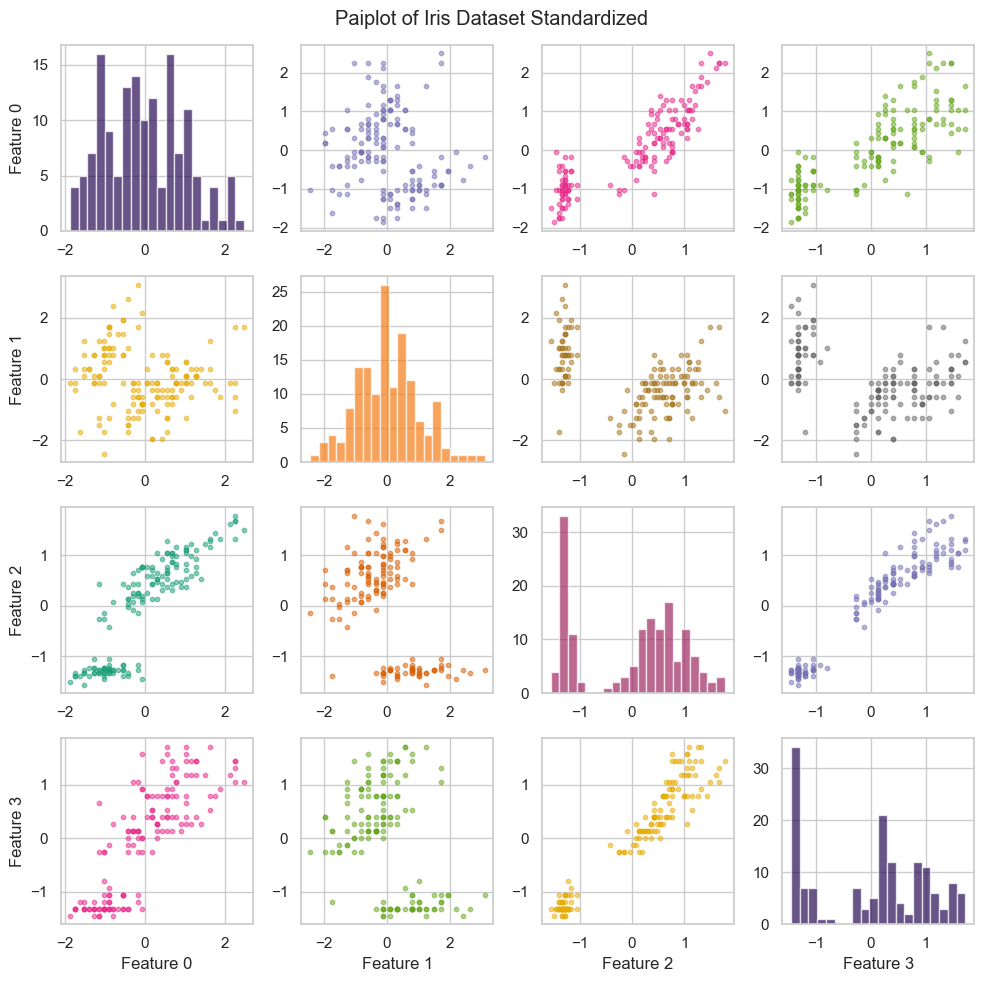

In [14]:
pairplot(X_iris_std, "Paiplot of Iris Dataset Standardized")

Using a combination of features from different parts of the flower, like sepal width and petal length, can be useful in some contexts, particularly when investigating relationships between different categories. However, for K-means, which relies heavily on distance metrics, this mix can complicate the formation of distinct clusters, especially if the scales or variances of these features differ significantly.

In the Iris dataset, it’s generally observed that petal features offer a clearer separation between species, and standardizing these features can enhance cluster formation. Petal measurements, after standardization, tend to be more effective for K-means because the distances between points better reflect the actual differences between clusters.

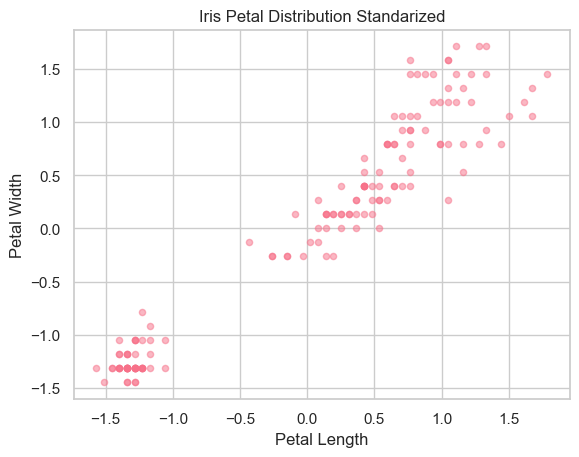

In [15]:
X_petal = X_iris_std[:, [2, 3]]

display_cluster(
    X_petal,
    title="Iris Petal Distribution Standarized",
    feature_x="Petal Length",
    feature_y="Petal Width",
)

The Iris Plant dataset is a case where we already know the data structure and the number of clusters in which they should be grouped. However, in real-world scenarios, we often lack this valuable information. This is where unsupervised learning algorithms become crucial, as they allow us to uncover patterns and group data without predefined labels. To determine the optimal number of clusters for a model like K-means, we can apply methods such as the elbow method, among others previously discussed.

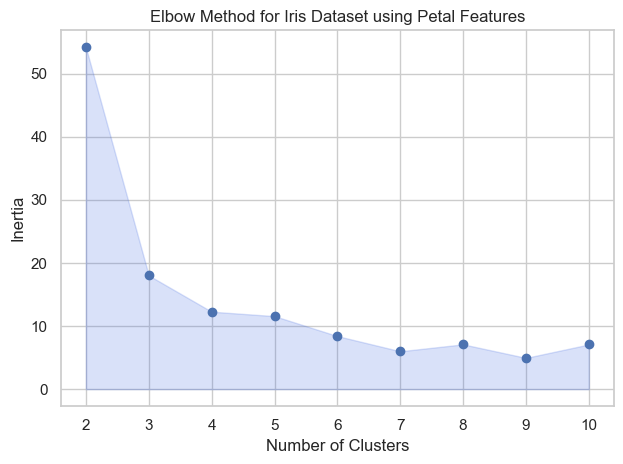

In [16]:
elbow_method(X_petal, title="for Iris Dataset using Petal Features")

Once we have determined the optimal number of segments for our data, we can fine-tune our configurations and select the distribution that best aligns with the goals of our research.

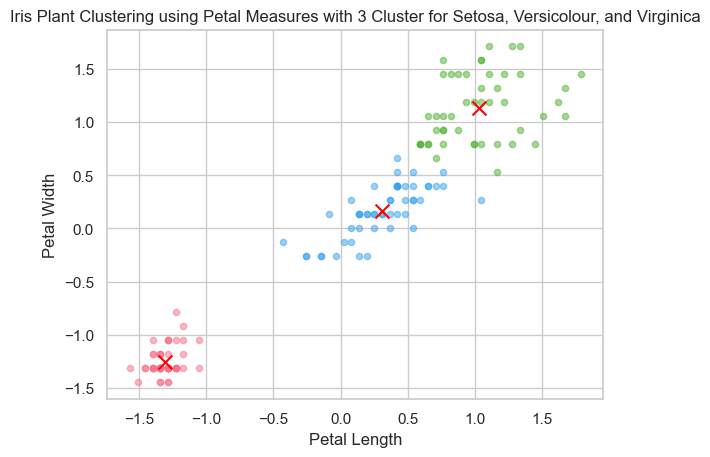

In [17]:
num_clusters = 3
km_iris = Kmeans(k=num_clusters)
labels, centroids = km_iris.predict(X_petal)

display_cluster(
    X_petal,
    km_iris,
    num_clusters,
    title="Iris Plant Clustering using Petal Measures with 3 Cluster for Setosa, Versicolour, and Virginica",
    feature_x="Petal Length",
    feature_y="Petal Width",
)

## Wine Dataset Testing

- [Scikit-Learn Toy Datasets - Wine recognition dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-dataset)

The Wine dataset from sklearn contains chemical properties of three different wine types, allowing for the analysis and clustering of these properties to uncover hidden patterns without supervision. While it lacks a clear 2D visualization of clusters, unlike the Iris dataset, its high dimensionality makes it an ideal challenge for KMeans. Instead of relying on direct visual separation, clustering success can be evaluated using metrics like inertia or silhouette analysis. With 13 features, including acidity, alcohol content, and malic acid concentration, the dataset provides diverse information that allows for exploring complex and meaningful groupings in multidimensional space.

This complexity makes the Wine dataset a more realistic option for testing KMeans, mimicking real-world scenarios where data isn't easily separable visually but can still be segmented into significant clusters using unsupervised learning techniques.

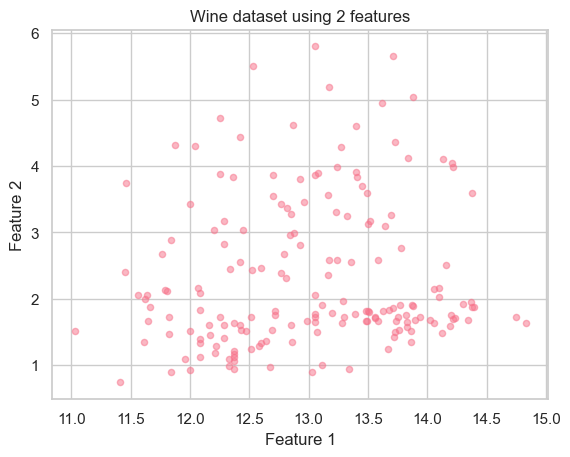

In [18]:
X_wine = load_wine().data

display_cluster(X_wine, title="Wine dataset using 2 features", feature_x="Feature 1", feature_y="Feature 2")

In [19]:
X_wine_std = StandardScaler().fit_transform(X_wine)

In this analysis, we use two key features from the Wine dataset, Alcohol and Proline, due to their clear variability and ability to differentiate wine types. By focusing on these two dimensions, we simplify the analysis and reduce computational complexity, effectively visualizing the clusters formed by K-Means. This strategic feature selection aims to improve the algorithm's performance, providing a clear representation before extending the analysis to a more complex dataset.

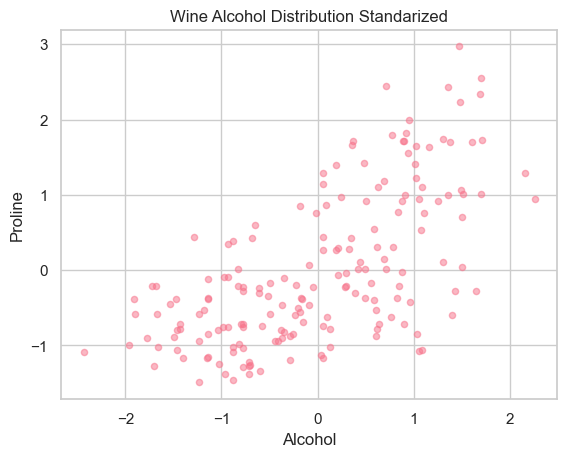

In [20]:
X_alcohol = X_wine_std[:, [0, 12]]

display_cluster(
    X_alcohol,
    title="Wine Alcohol Distribution Standarized",
    feature_x="Alcohol",
    feature_y="Proline",
)

There is a difference in the distribution of the data taking into account only the columns mentioned above. 

If we now apply the elbow method and silhouette analysis to determine our optimal number of clusters with the original dataset or with the bounded dataset, we can define k based on our problem context.

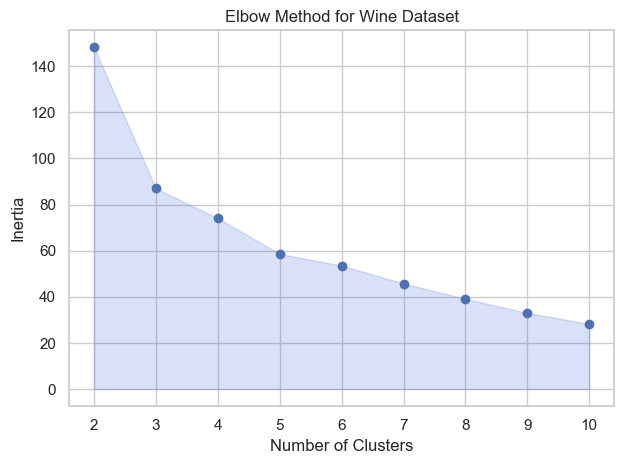

In [21]:
elbow_method(X_alcohol, title="for Wine Dataset")

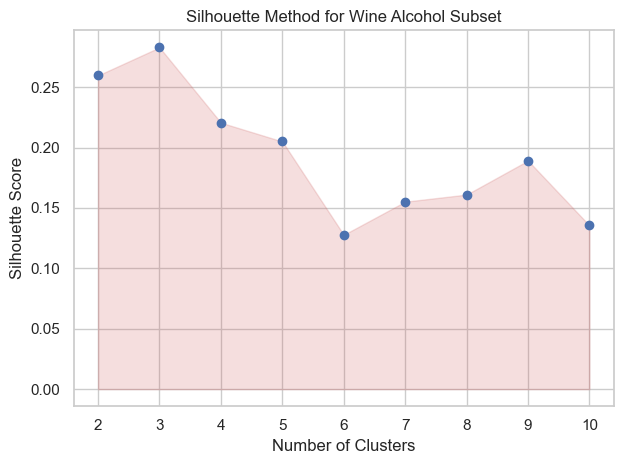

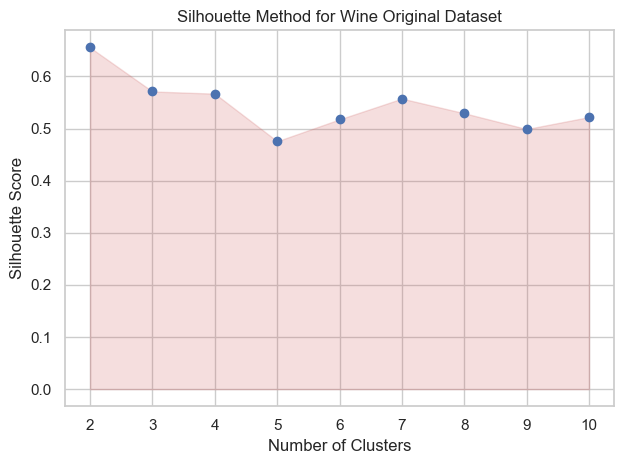

In [22]:
silhouette_analysis(X_wine_std, title="for Wine Alcohol Subset")
silhouette_analysis(X_wine, title="for Wine Original Dataset")

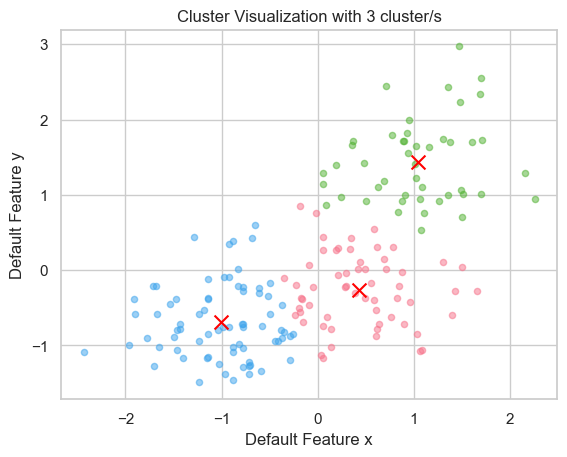

In [23]:
num_clusters = 3
km_wine = Kmeans(k=num_clusters)
labels, centroids = km_wine.predict(X_alcohol)

display_cluster(
    X_alcohol,
    km_wine,
    num_clusters,
)

## Clustering Classification Conclusion

Clustering classification using K-Means excels in its versatility across different contexts, but its success heavily depends on a clear understanding of the problem and a deep knowledge of the dataset. Tackling the problem with careful analysis of the most relevant features not only enhances the representativeness of the data but also reduces computational costs. Selecting key features, as we did with the Wine dataset, can simplify the analysis without sacrificing the accuracy of the formed clusters. Ultimately, the key to effective clustering lies in tailoring the model to the needs of the context and leveraging the inherent properties of the data to maximize algorithm performance.

## Image Segmentation

Image segmentation is a computer vision technique that partitions a digital image into discrete groups of pixels—image segments—to inform object detection and related tasks. By parsing an image’s complex visual data into specifically shaped segments, image segmentation enables faster, more advanced image processing.

Image classification applies a class label to an entire image. For example, a simple image classification model might be trained to categorize vehicle images as “car” or “truck”. Conventional image classification systems are limited in sophistication, as they do not process individual image features separately.

### Semantic segmentation

Semantic segmentation is the simplest type of image segmentation. A semantic segmentation model assigns a semantic class to every pixel, but doesn’t output any other context or information (like objects).

Semantic segmentation treats all pixels as stuff; it does not differentiate between stuff and things.

For example, a semantic segmentation model trained to identify certain classes on a city street would yield segmentation masks indicating the boundaries and contours for each relevant class of thing (like vehicles or light poles) and stuff (like roads and sidewalks), but not make any distinction between (or count the number of) multiple instances of the same class. For example, cars parked one in front of the other might be simply treated as one long “car” segment.

We can extract an image from Internet to test our K-means model for image segmentation.

In [31]:
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

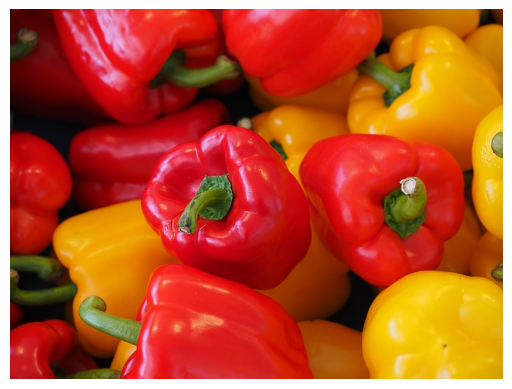

In [32]:
img = url_to_image("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%201/images/peppers.jpg")

plt.imshow(img)
plt.axis("off")
plt.show()

In this experiment, we applied a KMeans algorithm to segment the original image of red and yellow peppers. The original image contains a high level of detail in terms of color and shapes, which were simplified by clustering colors into distinct segments, with each segment represented by a single average color.

In [79]:
def simple_img_seg(img, num_clusters=3, inertia=False):
    pixel_values = np.float32(img.reshape((-1, 3)))

    km_img = Kmeans(k=num_clusters)
    km_img.predict(pixel_values, inertia=True)

    centroids = np.uint8(km_img.centroids)
    labels = km_img.labels

    # assert labels.size == pixel_values.shape[0], "The number of labels does not match the number of pixels."

    segmented_data = centroids[km_img.labels]
    # assert segmented_data.shape[0] == pixel_values.shape[0], "The size of the segmented data does not match the number of pixels."

    result_image = segmented_data.reshape(img.shape)

    if inertia:
        return result_image, np.float32(km_img.inertia)
    else:
        return result_image

### Notes about Simple Image Segmentation

The following code line:
```python
pixel_values = np.float32(img.reshape((-1, 3)))

```
**What does this line do?**

- `img.reshape((-1, 3))`: The reshape function in NumPy changes the shape (dimensions) of an array. The original image img has the shape `(height, width, 3)`, where 3 represents the RGB color channels (Red, Green, Blue).

- `-1`: The value `-1` is a wildcard in NumPy, which means "*automatically calculate this dimension*." Essentially, you are telling NumPy, "*put whatever number fits here to make everything align correctly*." In this case, NumPy reshapes the image into a 2D array of size `(height * width, 3)`, where `height * width` represents all the pixels in the image, and `3` still represents the RGB color channels.

    - For example, if the image is 640 pixels wide and 480 pixels tall, the original shape would be `(480, 640, 3)`. By applying `reshape((-1, 3))`, the image becomes a matrix with the shape `(307200, 3)`, where `307200 = 480 * 640`.

**Why do we do this?**

The reason for doing this is that machine learning algorithms, like K-means, work with 2D matrices where each row represents a sample (in this case, a pixel) and each column represents a feature (in this case, the RGB values of the pixel). By converting the image into a 2D matrix of shape `(num_pixels, 3)`, we can process each pixel as a separate sample with three features (the RGB values).

**Why do we convert to `float32`?**

1. **Precise calculations**: Floating-point values allow for greater precision in mathematical calculations, which is important for operations like calculating distances between points in RGB space (used by K-means to compute centroids).

2. **Machine learning algorithms**: Many clustering and machine learning algorithms are designed to work with floating-point data. This improves performance and ensures that there are no truncation errors or limitations when using integers in calculations that require precision.


**Is it always -1 and 3?**

The `-1` and `3` are specific to RGB images. For grayscale images, we would use `reshape((-1, 1))`, and for RGBA images, it would be `reshape((-1, 4))` to account for all present channels.

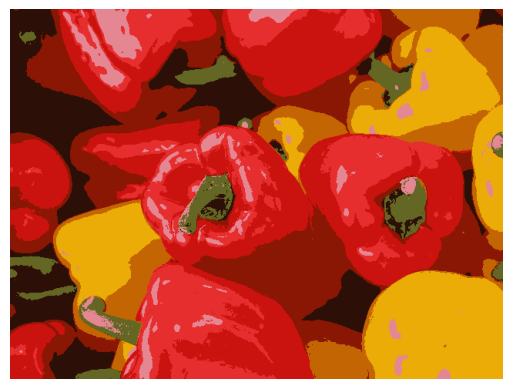

In [62]:
result_image, _ = simple_img_seg(img, num_clusters=8)

plt.imshow(result_image)
plt.axis('off')
plt.show()

In [67]:
k_vals = np.arange(2, 21, 2)
img_list = []
inertia = []

for k in k_vals:
    result_image, inertia_k = simple_img_seg(img, num_clusters=k)
    img_list.append(result_image)
    inertia.append(inertia_k)

The elbow method is a useful technique in image segmentation to determine the optimal number of clusters. When segmenting an image, we group pixels with similar characteristics (such as color or intensity) to simplify its representation. Choosing the right number of clusters is crucial to ensuring effective segmentation, as too few clusters can result in the loss of important image details, while too many clusters may introduce unnecessary noise and increase computational complexity.

The elbow method helps find a balance by analyzing how inertia (the internal variation within clusters) decreases as the number of clusters increases. The goal is to identify a point on the curve where the reduction in inertia becomes less significant, indicating that adding more clusters does not considerably improve segmentation. This point, known as "the elbow," suggests the optimal number of clusters for image segmentation.

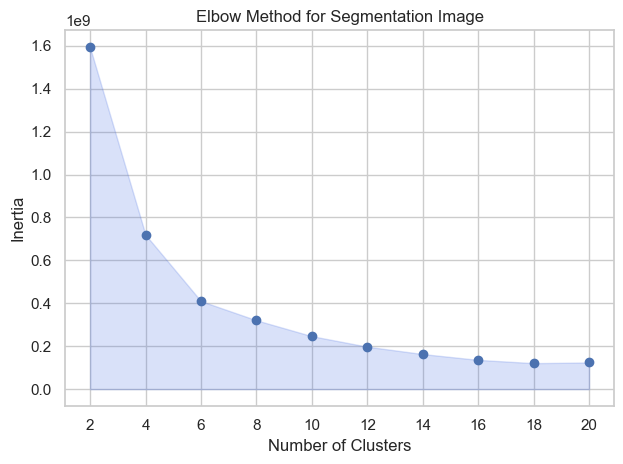

In [78]:
elbow_method(k_vals=k_vals, inertia=inertia, title="for Segmentation Image")

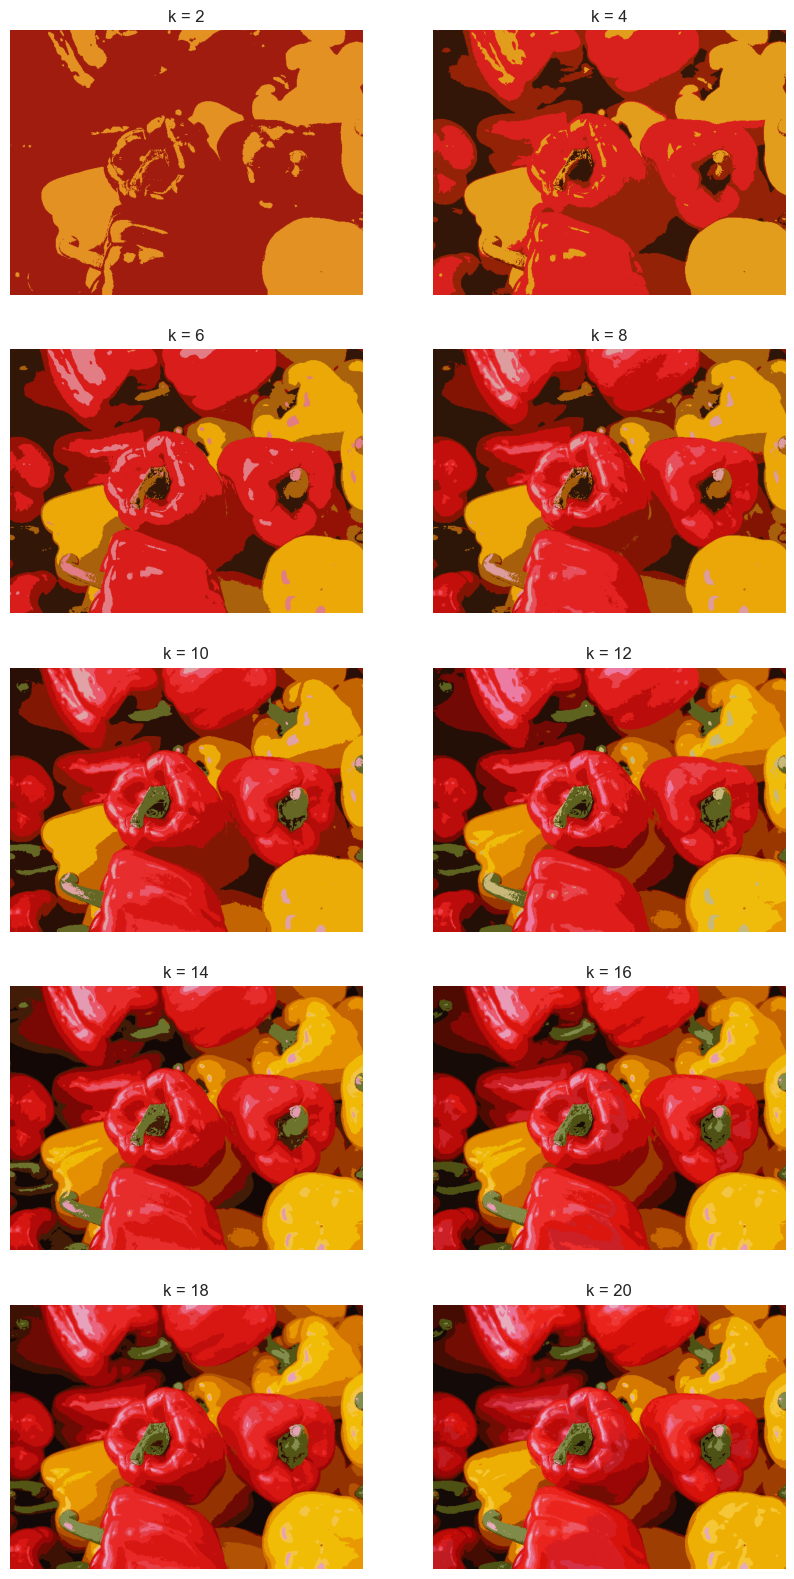

In [77]:
plt.figure(figsize=[10,20])
for i in range(len(k_vals)):
    plt.subplot(5,2,i+1)
    plt.imshow(img_list[i])
    plt.title('k = '+ str(k_vals[i]))
    plt.axis('off');

As we increased the number of clusters k, we observed how the segmentation gradually improved, capturing more details of the image. For example, with `k = 2`, the image is highly simplified with minimal details, while with higher values like `k = 12` or `k = 20`, the segmentation starts to more accurately reflect the original colors and structural features of the peppers. This demonstrates how the parameter `k` influences the level of detail and accuracy in the segmentation.

## Image Segmentation Conclusion

This type of segmentation is useful in many computer vision applications, such as image compression, medical analysis, and object detection. Additionally, it paves the way for deeper analysis, such as improving results by adapting the centroids or applying other more sophisticated segmentation algorithms.